<a href='https://www.kaggle.com/code/tommyadams/apples-gan'
target="_blank"><img align="left" 
alt="Kaggle" 
title="Open in Kaggle" 
src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <center> Apples GAN </center>

<center><img src='https://www.sagefruit.com/wp-content/uploads/2016/08/our-fruit-apples-1.jpg' height=400px width=400px></center>

## Project Summary

Generative Adversarial Networks (GANs) have revolutionized the field of machine learning by enabling the creation of synthetic data that closely resembles real-world examples. These networks consist of two key components: the generator and the discriminator, which engage in a competitive learning process. The generator network fabricates images, while the discriminator network learns to distinguish between genuine and synthetic images. Through a tug-of-war dynamic, these networks iteratively refine each other, ultimately leading to the generation of images that are progressively difficult to differentiate from authentic examples. GANs have been used for various applications, and have also sparked concerns due to their association with the creation of manipulated content like deep fakes. 

In this project, I created a GAN using PyTorch and trained it to generate lifelike images of apples. The architecture of the GAN draws inspiration from the 2016 paper titled "Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks." This paper pioneered the usage of convolutional layers in the discriminator network and convolutional-transpose layers in the generator network. Both networks employ a series of convolutional layers, ReLU activation functions, and normalization techniques.

While adhering to this general architecture, I made certain modifications to the GAN for this project:

- Sigmoid Activation: Unlike the original paper's use of a tanh function, I used a sigmoid function for the final layer of the generator. This alteration was made to align with the requirements of the image plotting function imshow.

- Enhanced Discriminator Communication: To facilitate enhanced communication between different areas of the image, the discriminator used two linear layers after its convolutions. 

- Dropout Regularization: Overfitting is a common concern in deep learning. To mitigate this, a dropout layer was integrated into the discriminator. This regularization technique aids in preventing the discriminator from becoming overly specialized to the training dataset, thus promoting better generalization.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import glob
import numpy as np

torch.manual_seed(300)

In [2]:
# Dataset from https://www.kaggle.com/datasets/moltean/fruits
# Only used the apple images
path = '/Users/tommyadams/Downloads/Apples'
img_paths = glob.glob(path + "/*/*jpg")

In [3]:
# Resizing images and converting to RGB array
img_list = []
for i in img_paths[:]:
    try:
        img = cv2.imread(i) 
        img = cv2.resize(img, (64,64)) # Resizing
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting to RGB
        img_list.append(img)
    except:
        pass

paints = np.stack(img_list, axis=-1)

In [4]:
# Converting images to a tensor (Img #, RGB #, pixel rows, pixel columns)
paints = paints.transpose(3, 2, 0, 1)
paints = torch.from_numpy(paints).int()
print(paints.shape)

torch.Size([6404, 3, 64, 64])


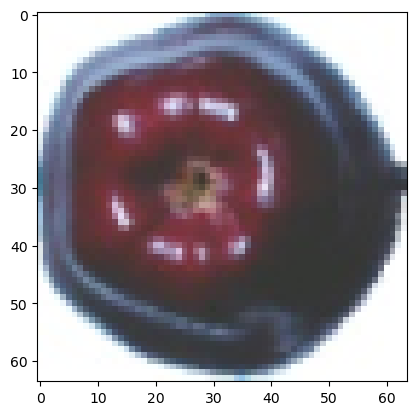

In [5]:
# Plotting one of the training images
plt.imshow(paints[0].transpose(0, 2))

In [6]:
class Descriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(6),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(6, 12, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(12),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(12, 24, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(24),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(24, 48, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(48),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(48, 96, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.linear1 = nn.Linear(384, 60)
        self.linear2 = nn.Linear(60, 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 384)
        x = self.linear1(x)
        x = F.relu(x) + x # 
        x = F.dropout(x, 0.3) # Prevents descriminator from overfitting the real images
        x = self.linear2(x)
        x = torch.sigmoid(x)
        return x

# Testing the output. Descriminator should return a value between 0 and 1 for classifying an image as fake or real
model = Descriminator()
model(paints[:3].float())

tensor([[0.4783],
        [0.2675],
        [0.2436]], grad_fn=<SigmoidBackward0>)

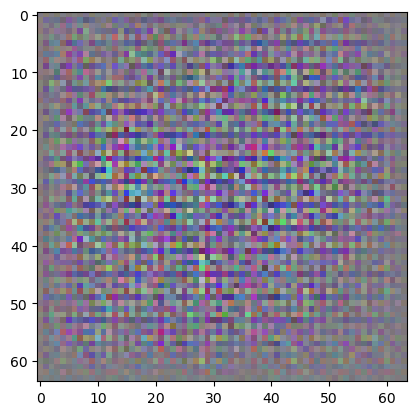

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(100, 2*2*240)  
        self.convt = nn.Sequential(
            nn.ConvTranspose2d(240, 120, kernel_size=4, stride=2, padding=1, bias=False), # 4 x 4
            nn.BatchNorm2d(120),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(120, 60, kernel_size=4, stride=2, padding=1, bias=False), # 8 x 8
            nn.BatchNorm2d(60),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(60, 30, kernel_size=4, stride=2, padding=1, bias=False), # 16 x 16
            nn.BatchNorm2d(30),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(30, 15, kernel_size=4, stride=2, padding=1, bias=False), # 32 x 32
            nn.BatchNorm2d(15),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(15, 3, kernel_size=4, stride=2, padding=1, bias=False), # 64 x 64
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.linear1(x)
        x = x.view(-1, 240, 2, 2)
        x = self.convt(x)
        return x

# Testing the ouput
model = Generator()
output = model(torch.rand(size=(100,)))
first_img = torch.transpose(output[0], 0, 2).detach().numpy()
plt.imshow(first_img)

In [8]:
# Initializing generator, descriminator, and data loader. 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 10
generator = Generator().to(device)
descriminator = Descriminator().to(device)
dataloader = torch.utils.data.DataLoader(paints, batch_size=batch_size, shuffle=True)     

Gen Loss: tensor(1.3874, grad_fn=<MeanBackward0>)
Des Loss: tensor(1.3082, grad_fn=<MeanBackward0>)


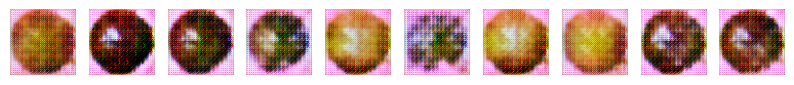

Gen Loss: tensor(1.1767, grad_fn=<MeanBackward0>)
Des Loss: tensor(1.2998, grad_fn=<MeanBackward0>)


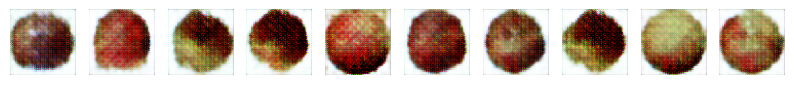

Gen Loss: tensor(1.0611, grad_fn=<MeanBackward0>)
Des Loss: tensor(1.3156, grad_fn=<MeanBackward0>)


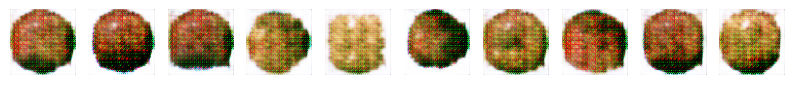

Gen Loss: tensor(1.0879, grad_fn=<MeanBackward0>)
Des Loss: tensor(1.3124, grad_fn=<MeanBackward0>)


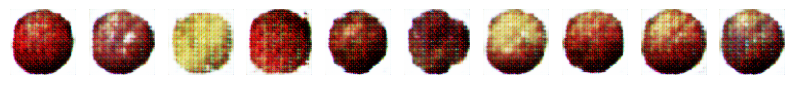

Gen Loss: tensor(1.1047, grad_fn=<MeanBackward0>)
Des Loss: tensor(1.3079, grad_fn=<MeanBackward0>)


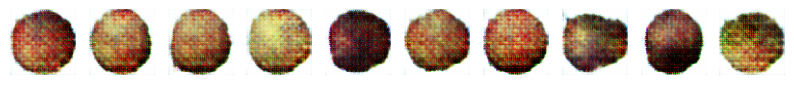

Gen Loss: tensor(1.2552, grad_fn=<MeanBackward0>)
Des Loss: tensor(1.2688, grad_fn=<MeanBackward0>)


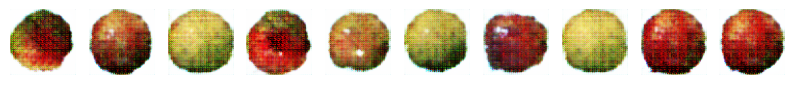

Gen Loss: tensor(1.3587, grad_fn=<MeanBackward0>)
Des Loss: tensor(1.2326, grad_fn=<MeanBackward0>)


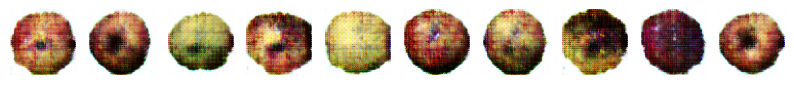

Gen Loss: tensor(1.6347, grad_fn=<MeanBackward0>)
Des Loss: tensor(1.1179, grad_fn=<MeanBackward0>)


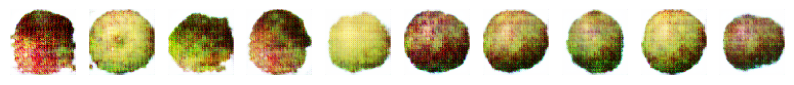

Gen Loss: tensor(2.0509, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.9824, grad_fn=<MeanBackward0>)


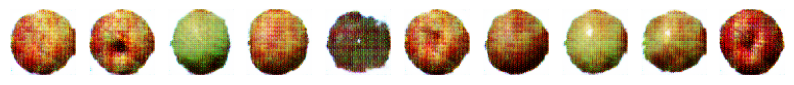

Gen Loss: tensor(2.3410, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.8583, grad_fn=<MeanBackward0>)


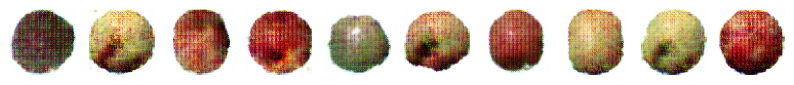

In [9]:
# Training Loop   
def training_loop(gen_lr, des_lr, epochs):
    
    # Initializing the optimizers 
    gen_opt = torch.optim.AdamW(generator.parameters(), lr=gen_lr, betas=(0.5,0.999))
    des_opt = torch.optim.AdamW(descriminator.parameters(), lr=des_lr, betas=(0.5,0.999))      
        
    for epoch in range(epochs):
        g_loss_list = []
        d_loss_list = []
    
        for i, batch in enumerate(dataloader, 0):
            
            # Training the descriminator on the real images
            des_opt.zero_grad(set_to_none=True)
            predict = descriminator(batch.float())
            d_loss = F.binary_cross_entropy(predict, torch.ones((len(predict),1), device=device)) 
            d_loss.backward()
            
            # Training the descriminator on the fake images
            rand_noise = torch.randn(batch_size, 100, device=device)
            gen_img = generator(rand_noise)
            predict = descriminator(gen_img.detach().to(device))
            d_loss_fake = F.binary_cross_entropy(predict,torch.zeros((len(predict),1), device=device))
            d_loss_fake.backward()
            des_opt.step()
        
            # Training the generator on the descriminator's feedback
            gen_opt.zero_grad(set_to_none=True)
            predict = descriminator(gen_img)
            g_loss = F.binary_cross_entropy(predict,torch.ones((len(predict),1), device=device))
            g_loss.backward()
            gen_opt.step()
            
            # Storing the losses
            g_loss_list.append(g_loss)
            d_loss_list.append(d_loss + d_loss_fake)

        # Print the avg loss for the epoch
        print('Gen Loss:', torch.mean(torch.stack(g_loss_list))) 
        print('Des Loss:', torch.mean(torch.stack(d_loss_list)))
        
        # Plot 10 fake apples
        fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10,1))
        for i in range(10):
            axes[i].axis('off')
            axes[i].imshow(torch.transpose(gen_img[i], 0, 2).detach().numpy())
        plt.show()
    
training_loop(.005, .005, 10)

Gen Loss: tensor(1.8622, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.5734, grad_fn=<MeanBackward0>)


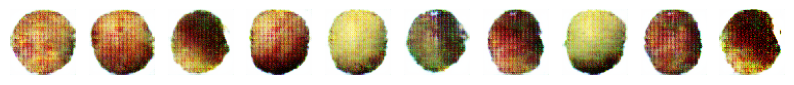

Gen Loss: tensor(2.3947, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.3816, grad_fn=<MeanBackward0>)


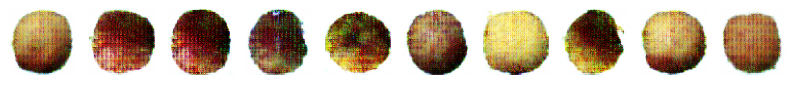

Gen Loss: tensor(2.8261, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.3277, grad_fn=<MeanBackward0>)


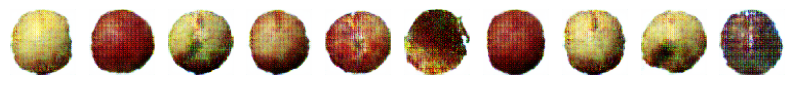

Gen Loss: tensor(3.1355, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.3102, grad_fn=<MeanBackward0>)


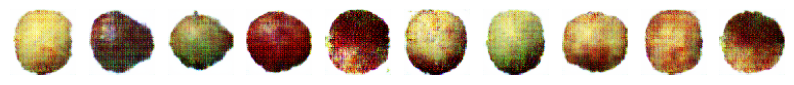

Gen Loss: tensor(3.2091, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.3474, grad_fn=<MeanBackward0>)


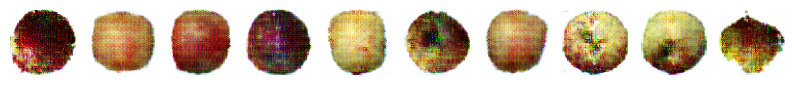

Gen Loss: tensor(3.2417, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.3645, grad_fn=<MeanBackward0>)


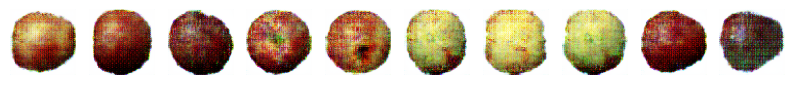

Gen Loss: tensor(3.3104, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.3526, grad_fn=<MeanBackward0>)


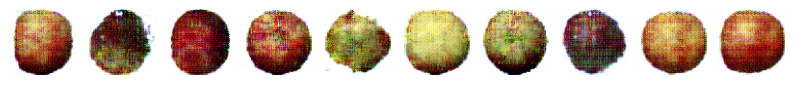

Gen Loss: tensor(3.3990, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.3240, grad_fn=<MeanBackward0>)


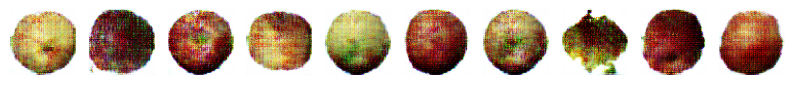

Gen Loss: tensor(3.5796, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.3054, grad_fn=<MeanBackward0>)


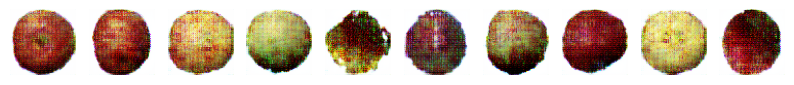

Gen Loss: tensor(3.6162, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.3032, grad_fn=<MeanBackward0>)


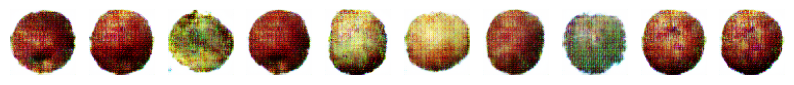

In [10]:
# Lowering the learning rate
training_loop(.0001, .0001, 10)

Gen Loss: tensor(3.8214, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.2750, grad_fn=<MeanBackward0>)


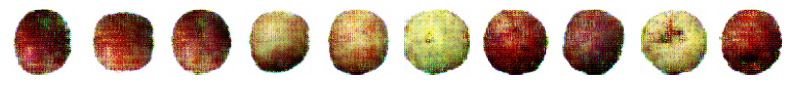

Gen Loss: tensor(3.9847, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.2916, grad_fn=<MeanBackward0>)


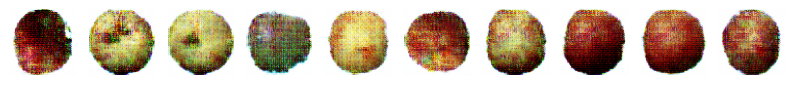

Gen Loss: tensor(3.9348, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.2975, grad_fn=<MeanBackward0>)


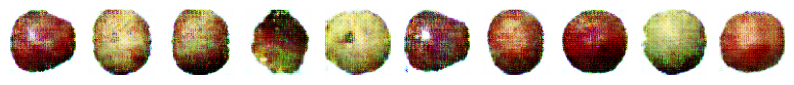

Gen Loss: tensor(3.8005, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.3303, grad_fn=<MeanBackward0>)


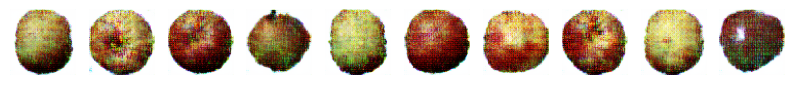

Gen Loss: tensor(3.8103, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.3114, grad_fn=<MeanBackward0>)


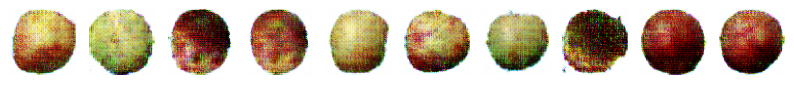

Gen Loss: tensor(3.8836, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.3130, grad_fn=<MeanBackward0>)


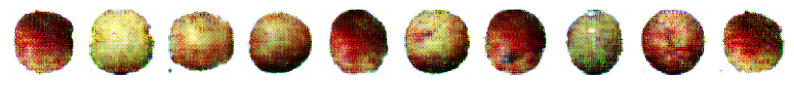

Gen Loss: tensor(3.8776, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.3219, grad_fn=<MeanBackward0>)


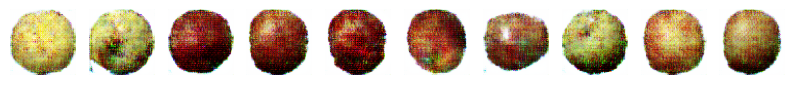

Gen Loss: tensor(3.9154, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.2990, grad_fn=<MeanBackward0>)


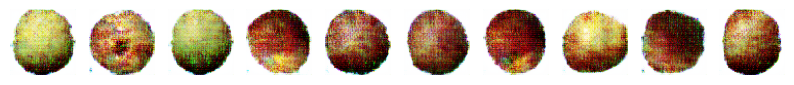

Gen Loss: tensor(3.9416, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.3109, grad_fn=<MeanBackward0>)


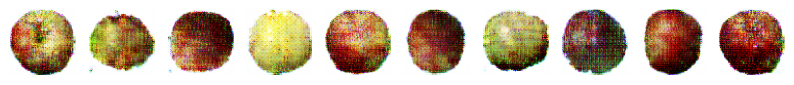

Gen Loss: tensor(3.9290, grad_fn=<MeanBackward0>)
Des Loss: tensor(0.3058, grad_fn=<MeanBackward0>)


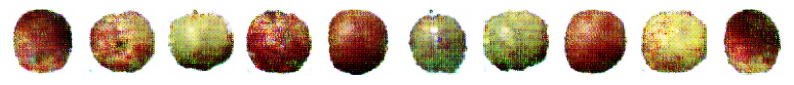

In [11]:
# More training
training_loop(.0001, .0001, 10)

## Results

While the final generated images are clearly different from those in the dataset, there has been remarkable progress from the initial stages of the project. The model's evolution showcases its potential for creating diverse apple images with varying positions, colors, and lighting conditions.

One of the central challenges of this project was parameter tuning. Experimenting with different learning rates, discriminator dropout rates, and the number of layers in the generator model presented a complex challenge. A recurring issue was that the descriminator frequently became so effective at identifying fake apples that the generator was no longer able to learn from it.

I decided to stop training the model at this point because the improvements were beginning to plateau, and I wanted the results to be easily reproducible without extensive computational resources. 

This project serves as a demonstration of what a GAN can achieve with a relatively modest amount of computational power. Clearly, there is a lot of room for improvement. Using GPUs and distributed training would boost computational power and enable the model to become more complex with additional layers and larger image sizes, likely yielding more impressive results. 